In [134]:
import pandas as pd
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# EDA

In [135]:
data = pd.read_csv("data/data-2/Kickstarter000.csv")

In [136]:
data.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,1387659690,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,...,new-final-round-album,https://www.kickstarter.com/discover/categorie...,True,False,successful,1391899046,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",802.0,international


In [137]:
# check out colum that looks like json
data["category"].iloc[3]

'{"id":266,"name":"Footwear","slug":"fashion/footwear","position":5,"parent_id":9,"color":16752598,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/fashion/footwear"}}}'

## Baseline Model 2.


### Baseline Model 2 with sample dataset (csv 0)

In [138]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   backers_count             3779 non-null   int64  
 1   blurb                     3779 non-null   object 
 2   category                  3779 non-null   object 
 3   converted_pledged_amount  3779 non-null   int64  
 4   country                   3779 non-null   object 
 5   created_at                3779 non-null   int64  
 6   creator                   3779 non-null   object 
 7   currency                  3779 non-null   object 
 8   currency_symbol           3779 non-null   object 
 9   currency_trailing_code    3779 non-null   bool   
 10  current_currency          3779 non-null   object 
 11  deadline                  3779 non-null   int64  
 12  disable_communication     3779 non-null   bool   
 13  friends                   8 non-null      object 
 14  fx_rate 

In [139]:
# We look at fx_rate, goal, state
# create dataframe with columns needed for the baseline
df_bs = data[["goal", "fx_rate", "state"]]

In [140]:
df_bs.head()

,goal,fx_rate,state
0,200.0,1.000000,successful
1,400.0,1.000000,successful
2,27224.0,1.000000,successful
3,40000.0,1.128433,successful
4,1000.0,1.000000,failed


In [141]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   goal     3779 non-null   float64
 1   fx_rate  3779 non-null   float64
 2   state    3779 non-null   object 
dtypes: float64(2), object(1)
memory usage: 88.7+ KB


In [142]:
df_bs.state.unique()

array(['successful', 'failed', 'live', 'canceled', 'suspended'],
      dtype=object)

In [143]:
df_bs.drop(df_bs[df_bs["state"] == "live"].index, inplace=True)
df_bs.drop(df_bs[df_bs["state"] == "canceled"].index, inplace=True)
df_bs.drop(df_bs[df_bs["state"] == "suspended"].index, inplace=True)

In [144]:
df_bs.state.unique()

array(['successful', 'failed'], dtype=object)

In [145]:
df_bs["all_usd"] = df_bs["goal"] * df_bs["fx_rate"]

In [146]:
df_bs.head()

,goal,fx_rate,state,all_usd
0,200.0,1.000000,successful,200.000
1,400.0,1.000000,successful,400.000
2,27224.0,1.000000,successful,27224.000
3,40000.0,1.128433,successful,45137.302
4,1000.0,1.000000,failed,1000.000


In [147]:
df_bs.drop(["goal", "fx_rate"], axis="columns", inplace=True)
df_bs.describe()

,all_usd
count,3.500000e+03
mean,2.200860e+04
std,1.313098e+05
min,7.512245e-01
25%,1.325680e+03
50%,4.891480e+03
75%,1.200000e+04
max,5.000000e+06


In [148]:
df_bs.head()

,state,all_usd
0,successful,200.000
1,successful,400.000
2,successful,27224.000
3,successful,45137.302
4,failed,1000.000


<AxesSubplot:>

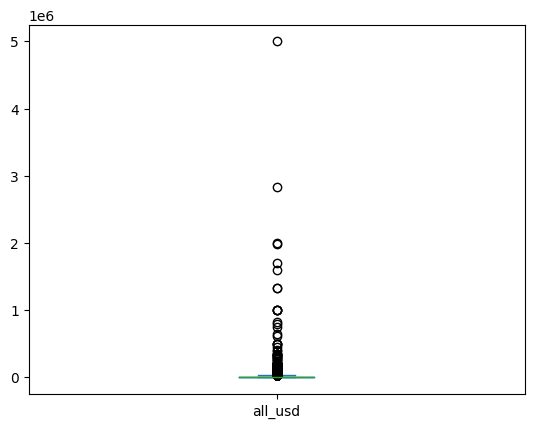

In [149]:
df_bs.plot(kind="box", x="state", y="all_usd")

In [150]:
all_usd_med = df_bs.all_usd.median()
all_usd_mean = df_bs.all_usd.mean()
print(f"med: {all_usd_med}, mean: {all_usd_mean}")

med: 4891.479625, mean: 22008.597004688632


In [151]:

df_bs["above_median"] =  df_bs.all_usd.apply(lambda x: 1 if x > all_usd_med else 0)
df_bs["above_mean"] =  df_bs.all_usd.apply(lambda x: 1 if x > all_usd_mean else 0)

df_bs.head()


,state,all_usd,above_median,above_mean
0,successful,200.000,0,0
1,successful,400.000,0,0
2,successful,27224.000,1,1
3,successful,45137.302,1,1
4,failed,1000.000,0,0


In [152]:
df_bs["state_transformed"] =  df_bs.state.apply(lambda x: 1 if x == "successful" else 0)


In [153]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = df_bs.state_transformed
y_pred_med = df_bs.above_median
y_pred_mean = df_bs.above_mean

print("Metrics for median: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_med))
print(classification_report(y_true, y_pred_med))

print("-------"*10)
print("Metrics for mean: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_mean))
print(classification_report(y_true, y_pred_mean))

Metrics for median: 
[[ 484  792]
 [1266  958]]
              precision    recall  f1-score   support

           0       0.28      0.38      0.32      1276
           1       0.55      0.43      0.48      2224

    accuracy                           0.41      3500
   macro avg       0.41      0.41      0.40      3500
weighted avg       0.45      0.41      0.42      3500

----------------------------------------------------------------------
Metrics for mean: 
[[ 928  348]
 [2010  214]]
              precision    recall  f1-score   support

           0       0.32      0.73      0.44      1276
           1       0.38      0.10      0.15      2224

    accuracy                           0.33      3500
   macro avg       0.35      0.41      0.30      3500
weighted avg       0.36      0.33      0.26      3500



### Baseline Model 2 with full dataset (all csv merged)

#### merging all csv files

In [154]:
all_files = glob.glob(os.path.join('data/data-2', "*.csv"))
all_files.sort()
all_files

['data/data-2/Kickstarter000.csv',
 'data/data-2/Kickstarter001.csv',
 'data/data-2/Kickstarter002.csv',
 'data/data-2/Kickstarter003.csv',
 'data/data-2/Kickstarter004.csv',
 'data/data-2/Kickstarter005.csv',
 'data/data-2/Kickstarter006.csv',
 'data/data-2/Kickstarter007.csv',
 'data/data-2/Kickstarter008.csv',
 'data/data-2/Kickstarter009.csv',
 'data/data-2/Kickstarter010.csv',
 'data/data-2/Kickstarter011.csv',
 'data/data-2/Kickstarter012.csv',
 'data/data-2/Kickstarter013.csv',
 'data/data-2/Kickstarter014.csv',
 'data/data-2/Kickstarter015.csv',
 'data/data-2/Kickstarter016.csv',
 'data/data-2/Kickstarter017.csv',
 'data/data-2/Kickstarter018.csv',
 'data/data-2/Kickstarter019.csv',
 'data/data-2/Kickstarter020.csv',
 'data/data-2/Kickstarter021.csv',
 'data/data-2/Kickstarter022.csv',
 'data/data-2/Kickstarter023.csv',
 'data/data-2/Kickstarter024.csv',
 'data/data-2/Kickstarter025.csv',
 'data/data-2/Kickstarter026.csv',
 'data/data-2/Kickstarter027.csv',
 'data/data-2/Kickst

In [155]:
merged_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [156]:
# create dataframe with columns needed for the baseline
df_baseline = merged_df[["goal", "fx_rate", "state"]]
df_baseline.state.unique()

array(['successful', 'failed', 'live', 'canceled', 'suspended'],
      dtype=object)

In [157]:
# we only look at successful and failed, so drop other rows
df_baseline.drop(df_baseline[df_baseline["state"] == "live"].index, inplace=True)
df_baseline.drop(df_baseline[df_baseline["state"] == "canceled"].index, inplace=True)
df_baseline.drop(df_baseline[df_baseline["state"] == "suspended"].index, inplace=True)
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192664 entries, 0 to 209221
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   goal     192664 non-null  float64
 1   fx_rate  192664 non-null  float64
 2   state    192664 non-null  object 
dtypes: float64(2), object(1)
memory usage: 5.9+ MB


In [217]:
# drop those states from df_merged as well
merged_df.drop(merged_df[merged_df["state"] == "live"].index, inplace=True)
merged_df.drop(merged_df[merged_df["state"] == "canceled"].index, inplace=True)
merged_df.drop(merged_df[merged_df["state"] == "suspended"].index, inplace=True)

Calculating the baseline f1-values again for the full dataset

In [218]:
df_baseline["calc_usd"] = df_baseline["goal"] * df_baseline["fx_rate"]
# add the "calc_usd" column to df_merged
merged_df["calc_goal_usd"] = merged_df["goal"] * df_baseline["fx_rate"]

calc_usd_med = df_baseline.calc_usd.median()
calc_usd_mean = df_baseline.calc_usd.mean()
print(f"med: {calc_usd_med}, mean: {calc_usd_mean}")

df_baseline["above_median"] =  df_baseline.calc_usd.apply(lambda x: 1 if x > calc_usd_med else 0)
df_baseline["above_mean"] =  df_baseline.calc_usd.apply(lambda x: 1 if x > calc_usd_mean else 0)
df_baseline["state_transformed"] =  df_baseline.state.apply(lambda x: 1 if x == "successful" else 0)



from sklearn.metrics import confusion_matrix, classification_report

y_true = df_baseline.state_transformed
y_pred_med = df_baseline.above_median
y_pred_mean = df_baseline.above_mean

print("Metrics for median: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_med))
print(classification_report(y_true, y_pred_med))

print("-------"*10)
print("Metrics for mean: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_mean))
print(classification_report(y_true, y_pred_mean))

med: 4993.789528, mean: 37129.537682956216
Metrics for median: 
[[28746 46453]
 [67587 49878]]
              precision    recall  f1-score   support

           0       0.30      0.38      0.34     75199
           1       0.52      0.42      0.47    117465

    accuracy                           0.41    192664
   macro avg       0.41      0.40      0.40    192664
weighted avg       0.43      0.41      0.42    192664

----------------------------------------------------------------------
Metrics for mean: 
[[ 62860  12339]
 [112582   4883]]
              precision    recall  f1-score   support

           0       0.36      0.84      0.50     75199
           1       0.28      0.04      0.07    117465

    accuracy                           0.35    192664
   macro avg       0.32      0.44      0.29    192664
weighted avg       0.31      0.35      0.24    192664



**Result Baseline 2**
The f1-score for the median is 47% for the full dataset compared to 48% for the first csv file.

## Feature engineering and data cleaning

The following columns will be used as predictors (sorted by importance desc) and should therefore exist with cleaned values in the full data set :
1. category
2. pledeged
3. created_at
4. launched_at
5. deadline

#### exploring category column and json datatype

In [159]:
data.name.unique()

array(['New Final Round Album', 'Princess Pals Enamel Pin Series',
       'Their Life Through Their Lens-the Amish and Mennonite People',
       ..., '"Summer Rec" Pilot Episode',
       "IT'S NOT ABOUT YOU: undergraduate student thesis film",
       'A cool and thought provoking t-shirt line.'], dtype=object)

In [160]:
data.slug.unique()

array(['new-final-round-album', 'princess-pals-enamel-pin-series',
       'their-life-through-their-lens-the-amish-and-mennon', ...,
       'summer-rec-pilot-episode',
       'its-not-about-you-undergraduate-student-thesis-fil',
       'a-cool-and-thought-provoking-t-shirt-line'], dtype=object)

In [161]:
import json

# some JSON:
x =  '{ "name":"John", "age":30, "city":"New York"}'

# parse x:
y = json.loads(x)

# the result is a Python dictionary:
print(y["age"])

30


In [162]:
json.loads(data.category[1])["parent_id"]

1

In [163]:
print(["parent_id"])

['parent_id']


In [164]:
data.category[1]

'{"id":54,"name":"Mixed Media","slug":"art/mixed media","position":6,"parent_id":1,"color":16760235,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/art/mixed%20media"}}}'

In [165]:
y = [[json.loads(data.category[i])["slug"],json.loads(data.category[i])["parent_id"]] for i in range(31)]

In [166]:
y.sort()

In [167]:
y

[['art/mixed media', 1],
 ['art/mixed media', 1],
 ['art/sculpture', 1],
 ['fashion/accessories', 9],
 ['fashion/accessories', 9],
 ['fashion/footwear', 9],
 ['fashion/footwear', 9],
 ['fashion/footwear', 9],
 ['food/restaurants', 10],
 ['food/small batch', 10],
 ['games/playing cards', 12],
 ['games/playing cards', 12],
 ['music/classical music', 14],
 ['music/classical music', 14],
 ['music/country & folk', 14],
 ['music/rock', 14],
 ['music/rock', 14],
 ['music/rock', 14],
 ['photography/fine art', 15],
 ['photography/nature', 15],
 ['photography/photobooks', 15],
 ['photography/photobooks', 15],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['technology/software', 16],
 ['technology/software', 16],
 ['technology/software', 16],
 ['theater/festivals', 17],
 ['theater/musical', 17]]

In [168]:
json.loads(data.category[0])["parent_id"]

14

In [169]:
y = [json.loads(data.category[i]).get("parent_id") for i in range(32)]

In [170]:
y

[14,
 1,
 15,
 9,
 16,
 9,
 18,
 16,
 1,
 12,
 15,
 18,
 9,
 9,
 12,
 10,
 15,
 15,
 17,
 1,
 14,
 14,
 10,
 16,
 18,
 17,
 9,
 14,
 14,
 14,
 18,
 None]

In [171]:
json_df = data['category'].apply(json.loads)
json_column = pd.DataFrame(json_df.tolist())

In [172]:
json_column.parent_id

0       14.0
1        1.0
2       15.0
3        9.0
4       16.0
        ... 
3774    14.0
3775    12.0
3776    11.0
3777    11.0
3778     9.0
Name: parent_id, Length: 3779, dtype: float64

In [173]:
json_column.shape

(3779, 7)

In [174]:
data_wide = pd.concat([data, json_column.parent_id], axis=1)

In [175]:
data_wide

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,parent_id
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,1387659690,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1391899046,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",802.00000,international,14.0
1,97,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2259,US,1549659768,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1551801611,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2259.00000,international,1.0
2,88,Helping a community come together to set the s...,"{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",29638,US,1477242384,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1480607932,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",29638.00000,international,15.0
3,193,Every revolution starts from the bottom and we...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",49158,IT,1540369920,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1544309940,1.136525,"{""web"":{""project"":""https://www.kickstarter.com...",49075.15252,international,9.0
4,20,Learn to build 10+ Applications in this comple...,"{""id"":51,""name"":""Software"",""slug"":""technology/...",549,US,1425706517,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1428511019,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",549.00000,domestic,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,10,"This is a collaborative effort at recording, m...","{""id"":316,""name"":""Blues"",""slug"":""music/blues"",...",506,US,1454527113,"{""id"":1000214737,""name"":""Penny D Marcucci"",""is...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1459716419,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",506.00000,domestic,14.0
3775,472,Get your own Mimic Chest containing dice vault...,"{""id"":270,""name"":""Gaming Hardware"",""slug"":""gam...",75790,US,1506288614,"{""id"":1342562240,""name"":""Polymorph Crafts"",""sl...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1510934334,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",75790.00000,international,12.0
3776,35,"A new animated, workplace comedy series about ...","{""id"":29,""name"":""Animation"",""slug"":""film & vid...",2346,US,1336120969,"{""id"":765327036,""name"":""Daran Carlin-Weber"",""i...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1339046590,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2346.00000,international,11.0
3777,13,a thesis film following the emotional life of ...,"{""id"":32,""name"":""Shorts"",""slug"":""film & video/...",1901,US,1537154407,"{""id"":1521393087,""name"":""Carolyn Ramella"",""is_...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1543349869,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1901.00000,international,11.0


In [176]:
data_wide.parent_id.unique()

array([14.,  1., 15.,  9., 16., 18., 12., 10., 17., nan,  6., 13., 11.,
        3., 26.,  7.])

#### creating lists of categories and ids

In [177]:
json_df = merged_df['category'].apply(json.loads)
json_column = pd.DataFrame(json_df.tolist())

In [178]:
legend = pd.concat([json_column.slug, json_column.parent_id], axis=1)

In [179]:
id_legend = legend.sort_values('parent_id').drop_duplicates().set_index('parent_id')

In [180]:
minislug = [json_column.slug[i].split('/')[0] for i in range(len(json_column))]

In [181]:
# all minislugs (category in string format) as data frame
df_mini = pd.DataFrame({'minislug':minislug})

In [182]:
df_mini.shape

(209222, 1)

In [183]:
legend = pd.concat([df_mini, json_column.parent_id], axis=1)

In [184]:
id_legend = legend.sort_values('parent_id').drop_duplicates().reset_index(drop=True)

In [185]:
id_legend

,minislug,parent_id
0,art,1.0
1,comics,3.0
2,dance,6.0
3,design,7.0
4,fashion,9.0
5,food,10.0
6,film & video,11.0
7,games,12.0
8,journalism,13.0
9,music,14.0


In [186]:
top_categories = legend.minislug.drop_duplicates().to_list()
full_categories = json_column.slug.drop_duplicates().to_list()


In [187]:
# function to map correct parent_id to a top category based on id_legend dataframe
def condition(x):
    cat = x['minislug']
    if (cat == 'art'):
        return 1.0
    elif (cat == 'comics'):
	    return 3.0
    elif (cat == 'dance'):
        return 6.0
    elif (cat == 'design'):
        return 7.0
    elif (cat == 'fashion'):
        return 9.0
    elif (cat == 'food'):
        return 10.0
    elif (cat == 'film & video'):
        return 11.0
    elif (cat == 'games'):
        return 12.0
    elif (cat == 'journalism'):
        return 13.0
    elif (cat == 'music'):
        return 14.0
    elif (cat == 'photography'):
        return 15.0
    elif (cat == 'technology'):
        return 16.0
    elif (cat == 'theater'):
        return 17.0
    elif (cat == 'publishing'):
        return 18.0
    elif (cat == 'crafts'):
        return 26.0

id_legend.parent_id = id_legend.apply(condition, axis=1)


**final top category list with ids**

In [188]:
# create final mapping dataframe to look at
id_legend.drop_duplicates().reset_index(drop=True)

,minislug,parent_id
0,art,1.0
1,comics,3.0
2,dance,6.0
3,design,7.0
4,fashion,9.0
5,food,10.0
6,film & video,11.0
7,games,12.0
8,journalism,13.0
9,music,14.0


In [206]:
print(top_categories)
print("-------"*10)
print (full_categories)

['music', 'art', 'photography', 'fashion', 'technology', 'publishing', 'games', 'food', 'theater', 'dance', 'crafts', 'journalism', 'film & video', 'comics', 'design']
----------------------------------------------------------------------
['music/rock', 'art/mixed media', 'photography/photobooks', 'fashion/footwear', 'technology/software', 'fashion/accessories', 'publishing/nonfiction', 'art/sculpture', 'games/playing cards', 'photography/fine art', 'food/restaurants', 'photography/nature', 'theater/festivals', 'music/classical music', 'food/small batch', 'theater/musical', 'music/country & folk', 'theater', 'theater/plays', 'fashion/apparel', 'photography', 'dance/workshops', 'music/r&b', 'music/pop', 'music', 'music/jazz', 'theater/experimental', 'art/performance art', 'photography/places', 'theater/comedy', 'photography/animals', 'music/indie rock', 'photography/people', 'fashion', 'theater/immersive', 'music/metal', 'crafts', 'theater/spaces', 'music/faith', 'fashion/pet fashion', 

besides using the top category - it might be worth to also look at the full category (the slug). The slug are more unique values but we might be able to say more precisely which category correlates with successful projects.

#### Creating columns for top level categories and their IDs

In [190]:
# create column top_cat using the minislug
merged_df["top_cat"] = [json_column.slug[i].split('/')[0] for i in range(len(json_column))]


In [191]:
def get_top_cat_id(x):
    cat = x['top_cat']
    if (cat == 'art'):
        return 1.0
    elif (cat == 'comics'):
	    return 3.0
    elif (cat == 'dance'):
        return 6.0
    elif (cat == 'design'):
        return 7.0
    elif (cat == 'fashion'):
        return 9.0
    elif (cat == 'food'):
        return 10.0
    elif (cat == 'film & video'):
        return 11.0
    elif (cat == 'games'):
        return 12.0
    elif (cat == 'journalism'):
        return 13.0
    elif (cat == 'music'):
        return 14.0
    elif (cat == 'photography'):
        return 15.0
    elif (cat == 'technology'):
        return 16.0
    elif (cat == 'theater'):
        return 17.0
    elif (cat == 'publishing'):
        return 18.0
    elif (cat == 'crafts'):
        return 26.0

merged_df["top_cat_id"] = np.nan
merged_df["top_cat_id"]= merged_df.apply(get_top_cat_id, axis=1)

In [197]:
print(merged_df[["top_cat", "top_cat_id"]])


            top_cat  top_cat_id
0             music        14.0
1               art         1.0
2       photography        15.0
3           fashion         9.0
4        technology        16.0
...             ...         ...
209217         food        10.0
209218         food        10.0
209219      fashion         9.0
209220   publishing        18.0
209221          art         1.0

[209222 rows x 2 columns]


#### pledged column


In [192]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

In [202]:
merged_df.columns
# there is no column "usd pledge real" that was converted by fixer.io

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type', 'top_cat',
       'top_cat_id'],
      dtype='object')

compare the currencies to decide if pledged needs to be converted

In [224]:
merged_df[merged_df["state"] == "successful"][["state", "goal", "calc_goal_usd", "pledged", "converted_pledged_amount", "usd_pledged", "current_currency", "currency", "fx_rate", "country"]]

,state,goal,calc_goal_usd,pledged,converted_pledged_amount,usd_pledged,current_currency,currency,fx_rate,country
0,successful,200.0,200.000000,802.0,802,802.000000,USD,USD,1.000000,US
1,successful,400.0,400.000000,2259.0,2259,2259.000000,USD,USD,1.000000,US
2,successful,27224.0,27224.000000,29638.0,29638,29638.000000,USD,USD,1.000000,US
3,successful,40000.0,45137.302000,43180.0,49158,49075.152520,USD,EUR,1.128433,IT
5,successful,400.0,523.357444,1509.0,2117,2141.826071,USD,GBP,1.308394,GB
...,...,...,...,...,...,...,...,...,...,...
209212,successful,35000.0,35000.000000,37835.0,37835,37835.000000,USD,USD,1.000000,US
209215,successful,17486.0,17486.000000,18608.0,18608,18608.000000,USD,USD,1.000000,US
209217,successful,10000.0,10000.000000,10320.0,10320,10320.000000,USD,USD,1.000000,US
209220,successful,1000.0,1000.000000,1400.0,1400,1400.000000,USD,USD,1.000000,US


Looking at "pledged" in different convertions (converted_pledged_amount, usd_pledged) none of those convertions are matching the exchange rate (fx_rate).
To stay consistent we are going to convert pledged with the fx_rate as we did with goal.

**creating new column calc_pledged_usd** 

In [225]:
merged_df["calc_pledged_usd"] = merged_df["pledged"] * merged_df["fx_rate"]

In [223]:
# to be deleted later....
#merged_df.drop(["calc_usd"], axis=1, inplace=True)

In [226]:
merged_df[merged_df["state"] == "successful"][["state", "goal", "calc_goal_usd", "pledged", "calc_pledged_usd"]]

,state,goal,calc_goal_usd,pledged,calc_pledged_usd
0,successful,200.0,200.000000,802.0,802.000000
1,successful,400.0,400.000000,2259.0,2259.000000
2,successful,27224.0,27224.000000,29638.0,29638.000000
3,successful,40000.0,45137.302000,43180.0,48725.717509
5,successful,400.0,523.357444,1509.0,1974.365957
...,...,...,...,...,...
209212,successful,35000.0,35000.000000,37835.0,37835.000000
209215,successful,17486.0,17486.000000,18608.0,18608.000000
209217,successful,10000.0,10000.000000,10320.0,10320.000000
209220,successful,1000.0,1000.000000,1400.0,1400.000000
